# THE MARCENKO–PASTUR (MP) PDF


Assymptotic distribution of eigenvalues of a specific random matrix. https://en.wikipedia.org/wiki/Marchenko%E2%80%93Pastur_distribution

All the code is adopted from https://www.amazon.com.be/-/en/Marcos-M-L%C3%B3pez-Prado/dp/1108792898.

In [4]:
import matplotlib.pyplot as plt
import numpy as np,pandas as pd

from sklearn.neighbors import KernelDensity
from scipy.optimize import minimize
from scipy.linalg import block_diag
from sklearn.covariance import LedoitWolf

In [5]:
def mpPDF(var,q,pts):
    # Marcenko-Pastur pdf
    # q=T/N (>1)
    # pts - amount of points
    eMin,eMax=var*(1-(1./q)**.5)**2,var*(1+(1./q)**.5)**2
    eVal=np.linspace(eMin,eMax,pts)
    pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
    pdf=pd.Series(pdf,index=eVal)
    return pdf

In [6]:

def getPCA(matrix):
# Get eVal,eVec from a !!!Hermitian matrix (cov matrix is a hermitian matrix)
    eVal,eVec=np.linalg.eigh(matrix) 
    indices=eVal.argsort()[::-1] # arguments for sorting eVal desc
    eVal,eVec=eVal[indices],eVec[:,indices]
    eVal=np.diagflat(eVal)
    return eVal,eVec


def fitKDE(obs,bWidth=.25,kernel='gaussian',x=None):
    # Fit kernel to a series of obs, and derive the prob of obs
    # x is the array of values on which the fit KDE will be evaluated
    if len(obs.shape)==1:obs=obs.reshape(-1,1)
    kde=KernelDensity(kernel=kernel,bandwidth=bWidth).fit(obs)
    if x is None:x=np.unique(obs).reshape(-1,1)
    if len(x.shape)==1:x=x.reshape(-1,1)
    logProb=kde.score_samples(x) # log(density)
    pdf=pd.Series(np.exp(logProb),index=x.flatten())
    return pdf

In [7]:
15000 / 250

60.0

In [8]:
np.random.seed(32)

N = 1000#1000  # num of vars #N = 250, T = 3000, nFacts = 50 -> Not bad
T = 15000#10000 # num of observations
tmp_nFact = 50
x = np.random.normal(0, 1, size = (T, N))
cor = np.corrcoef(x, rowvar=0) # cor.shape = (1000,1000). If rowvar=1 - row represents a var, with observations in the columns.
eVal0 , eVec0 = getPCA( cor ) 
pdf0 = mpPDF(1., q=x.shape[0]/float(x.shape[1]), pts=N)
pdf1 = fitKDE(np.diag(eVal0), bWidth=.09) #empirical pdf


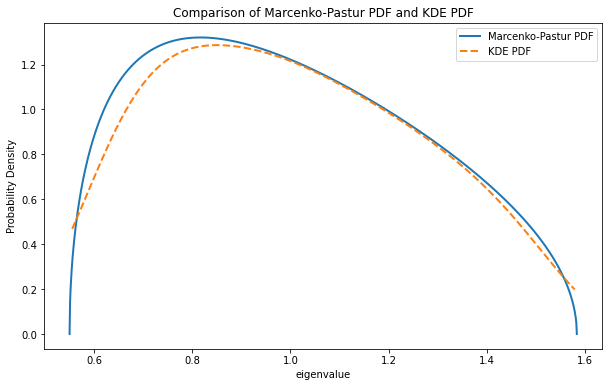

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(pdf0.keys(), pdf0, label='Marcenko-Pastur PDF', linewidth=2)
plt.plot(pdf1.keys(), pdf1, label='KDE PDF', linestyle='--', linewidth=2)
plt.title('Comparison of Marcenko-Pastur PDF and KDE PDF')
plt.xlabel('eigenvalue')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

In [10]:
def getRndCov(nCols, nFacts): #nFacts - contains signal out of nCols
    w = np.random.normal(size=(nCols, nFacts))
    cov = np.dot(w, w.T) #random cov matrix, however not full rank
    cov += np.diag(np.random.uniform(size=nCols)) #full rank cov
    return cov

def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std = np.sqrt(np.diag(cov))
    corr = cov/np.outer(std,std)
    corr[corr<-1], corr[corr>1] = -1,1 #for numerical errors
    return corr
    
def corr2cov(corr, std):
    cov = corr * np.outer(std, std)
    return cov     
    
#snippet 2.4 - fitting the marcenko-pastur pdf - find variance
#Fit error
def errPDFs(var, eVal, q, bWidth, pts=1000):
    var = var[0]
    pdf0 = mpPDF(var, q, pts) #theoretical pdf
    pdf1 = fitKDE(eVal, bWidth, x=pdf0.index.values) #empirical pdf
    sse = np.sum((pdf1-pdf0)**2)
    print("sse:"+str(sse))
    return sse 
    
# find max random eVal by fitting Marcenko's dist
# and return variance
def findMaxEval(eVal, q, bWidth):
    out = minimize(lambda *x: errPDFs(*x), x0=np.array(0.5), args=(eVal, q, bWidth), bounds=((1E-5, 1-1E-5),))
    print("found errPDFs"+str(out['x'][0]))
    if out['success']: var = out['x'][0]
    else: var=1
    eMax = var*(1+(1./q)**.5)**2
    return eMax, var

In [24]:
import numpy as np

def count_nFactors(T, N, alpha = .999):
    print(f'T={T}, N={N}')
    alpha, nCols, nFact, q = alpha, N, tmp_nFact, T // N
    pdf0 = mpPDF(1., q=q, pts=N)
    cov = np.cov(np.random.normal(size=(nCols*q, nCols)), rowvar=0) #size = (1000*10,1000)
    cov = alpha*cov+(1-alpha)*getRndCov(nCols, nFact) # noise + signal
    corr0 = cov2corr(cov)
    eVal01, eVec01 = getPCA(corr0)
    eMax0, var0 = findMaxEval(np.diag(eVal01), q, bWidth=.01)
    nFacts0 = eVal01.shape[0]-np.diag(eVal01)[::-1].searchsorted(eMax0)
    return nFacts0


import numpy as np

def generate_xy_pairs(num_points, x_range=(50, 1500), y_range=(500, 15000)):
    xs = np.linspace(x_range[0], x_range[1], num_points, dtype=int)
    ys = []

    for x in xs:
        # Find a y for this x that is within the y range and ensures y/x is an integer
        possible_ys = [y for y in range(y_range[0], y_range[1]+1) if y % x == 0]
        if not possible_ys:  # If no valid y found within range, skip this x
            continue
        y = np.random.choice(possible_ys)  # Randomly select a valid y
        ys.append(y)

    # Adjusting the lists in case we couldn't find enough valid ys
    xs = xs[:len(ys)]  # Ensure xs and ys are of the same length

    return xs, ys

num_points = 100  # Specify the number of points you want to generate
xs, ys = generate_xy_pairs(num_points)



def get_TNFs(alpha, nPs=100, N_range = (50, 1000), T_range=(500, 15000)):
    Ns, Ts = generate_xy_pairs(nPs, N_range, T_range)
    Fs = [count_nFactors(int(Ts[i]), int(Ns[i]), alpha) for i in range(nPs)]
    
    return np.array(Ts), np.array(Ns), np.array(Fs)

In [25]:
Ts, Ns, Fs = get_TNFs(0.999, 100)

T=1900, N=50
sse:10366.76319600458
sse:10366.762781331789
sse:256.9504941084944
sse:256.9504936501638
sse:256.9486548837949
sse:256.94865448963844
sse:256.94365480763065
sse:256.9436548094733
sse:256.94365469869416
sse:256.94365469870127
found errPDFs0.9996920246583452
T=4484, N=59
sse:20622.758847378784
sse:20622.758022468443
sse:49.202597260936486
sse:49.20257546778974
sse:45.876398699087375
sse:45.8763753943452
sse:40.21285672881683
sse:40.21286188906244
sse:39.92339514117991
sse:39.923392824993506
sse:39.85752557158343
sse:39.857525670249444
sse:39.857403140084536
sse:39.857403141700146
sse:39.85740310808099
sse:39.857403108079566
found errPDFs0.9924146151335282
T=5037, N=69
sse:19813.039043722325
sse:19813.038251200785
sse:71.79998948013416
sse:71.79999296577031
found errPDFs0.99999
T=12870, N=78
sse:44645.082497935655
sse:44645.08071213239
sse:387.6074775460879
sse:387.60736188813826
sse:464.5542851693319
sse:464.55409698776543
sse:296.05867381782883
sse:296.05868908050854
sse:29

sse:6.433508836837532
sse:6.4335088364257365
sse:6.433508836425727
found errPDFs0.9995284473155802
T=13500, N=270
sse:13605.342144181435
sse:13605.341599967764
sse:117.66511155346276
sse:117.66507873902549
sse:49.47149084847156
sse:49.4714988987124
sse:50.76971012232073
sse:50.769699039266996
sse:47.855503411999656
sse:47.85550346188674
sse:47.85544358910026
sse:47.855443587787285
sse:47.85544354695894
sse:47.85544354695903
found errPDFs0.9675808728517815
T=560, N=280
sse:198.7845293235051
sse:198.7845148045952
sse:6.62567040777728
sse:6.625670637918526
found errPDFs0.99999
T=8670, N=289
sse:8054.241166128557
sse:8054.24076785085
sse:33.856568822789036
sse:33.85655852264178
sse:23.813917133156618
sse:23.813922616229572
sse:21.176487882501654
sse:21.176485389726658
sse:20.698511875790118
sse:20.698512266720233
sse:20.68672979806226
sse:20.68672979412262
sse:20.686728606809247
sse:20.686728606826996
sse:20.686728606793984
sse:20.686728606793974
found errPDFs0.9769203243088536
T=9867, N=2

sse:3900.90035285454
sse:3900.900106344786
sse:17.372474250878213
sse:17.372468949767192
sse:12.41493476178071
sse:12.414938653105086
sse:10.259189697523897
sse:10.259187191501585
sse:8.795915681024779
sse:8.795915774992586
sse:8.794089180999242
sse:8.794089175675792
sse:8.794083336879266
sse:8.794083336904649
sse:8.794083336759037
sse:8.79408333675907
found errPDFs0.9714024594322287
T=14430, N=481
sse:8041.025804687715
sse:8041.025405284219
sse:68.721434313606
sse:68.72141628411447
sse:35.01618203659785
sse:35.01619334478935
sse:32.25609377015809
sse:32.25608245187003
sse:23.746138624930452
sse:23.746139948790052
sse:23.5960532090411
sse:23.596053113231044
sse:23.59530400331365
sse:23.59530400682974
sse:23.59530299134091
sse:23.59530299134947
sse:23.59530299133921
sse:23.595302991339246
found errPDFs0.9579855584887003
T=1964, N=491
sse:476.64805873383324
sse:476.6480217412403
sse:2.5584222824001346
sse:2.558422372507192
found errPDFs0.99999
T=5511, N=501
sse:2101.9678705330534
sse:210

C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: divide by zero encountered in true_divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: divide by zero encountered in true_divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5


sse:151.92192373673208
sse:151.92191390270642
sse:13.901044376620678
sse:13.90104480759964
found errPDFs0.99999
T=11704, N=616


C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: divide by zero encountered in true_divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: divide by zero encountered in true_divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5


sse:4506.147336653355
sse:4506.147057309127
sse:30.997090165816786
sse:30.99708220172556
sse:20.783872173700615
sse:20.78387882372379
sse:40.187209022237646
sse:40.18719433172801
sse:10.70629191366447
sse:10.706292239407814
sse:10.686574591661863
sse:10.686574558180617
sse:10.686362359116073
sse:10.686362358943231
sse:10.686362353377294
sse:10.686362353377422
found errPDFs0.958636401279496
T=8750, N=625
sse:2952.1869088612184
sse:2952.1867096912765
sse:16.118589783549435
sse:16.11858580903164
sse:12.332664298113366
sse:12.332668093887115
sse:7.7548612702254704
sse:7.754859360011778
sse:6.88347434215523
sse:6.883474877980857
sse:6.770581506041742
sse:6.770581625561713
sse:6.76451332353737
sse:6.764513325046433
sse:6.764512375783711
sse:6.764512375760299
sse:6.764512375542873
sse:6.7645123755428465
found errPDFs0.9624663756984305
T=5080, N=635
sse:1306.5294422801012
sse:1306.5293464608435
sse:3.6600301171346317
sse:3.6600293932040264
sse:3.414122284351084
sse:3.414122879676135
sse:2.6278

C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: divide by zero encountered in true_divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5


sse:138.71843623155064
sse:138.71842706639583
sse:10.459659340777257
sse:10.459659699195111
found errPDFs0.99999
T=14801, N=779


C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: divide by zero encountered in true_divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: divide by zero encountered in true_divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: divide by zero encountered in true_divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: invalid value encountered i

sse:4491.573817356471
sse:4491.573534938112
sse:39.98867049651954
sse:39.98866032651265
sse:23.959114281968574
sse:23.959122463357648
sse:43.30042309030236
sse:43.30040739119101
sse:9.345118774436207
sse:9.3451198270502
sse:9.231852572152786
sse:9.231852052818542
sse:9.197243647545587
sse:9.197243657763082
sse:9.197230077193609
sse:9.197230077290811
sse:9.197230076016114
sse:9.19723007601608
found errPDFs0.9518550627061172
T=8668, N=788
sse:2075.8355272178696
sse:2075.8353795254675
sse:11.140729331059692
sse:11.140726268908757
sse:8.260426041518672
sse:8.26042857708062
sse:6.695093664351974
sse:6.695091321207189
sse:4.432674424186173
sse:4.43267483159933
sse:4.359033642609658
sse:4.359033528520199
sse:4.353223971271643
sse:4.353223975832732
sse:4.353214556798135
sse:4.353214556839282
sse:4.353214556053142
sse:4.353214556053117
found errPDFs0.9605768433218187
T=3990, N=798
sse:641.7545948600235
sse:641.7545444603312
sse:1.6261819282208185
sse:1.6261816539076461
sse:1.5596451204326036
ss

C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: divide by zero encountered in true_divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5


sse:135.8835401706349
sse:135.88353114592297
sse:9.982261386052329
sse:9.982261730479658
found errPDFs0.99999
T=3424, N=856


C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: divide by zero encountered in true_divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: divide by zero encountered in true_divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: divide by zero encountered in true_divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: invalid value encountered i

sse:459.6209742335078
sse:459.6209390320466
sse:1.0306003296436235
sse:1.0306001485965075
sse:0.9870450012266385
sse:0.9870451560612632
sse:0.8647432073999536
sse:0.8647431584242995
sse:0.8716514739579988
sse:0.87165155148623
sse:0.8616609317391803
sse:0.8616609304809917
sse:0.8616588986979894
sse:0.8616588986956328
sse:0.8616588986896729
sse:0.861658898689668
found errPDFs0.9835751167398836
T=14705, N=865
sse:3848.565084585023
sse:3848.5648370387244
sse:31.23800104004562
sse:31.237992754937174
sse:18.991379949299965
sse:18.99138674363634
sse:36.643088061147814
sse:36.643074729947514
sse:6.582396296402748
sse:6.582397232969565
sse:6.474484293107588
sse:6.474483814523245
sse:6.438747931997302
sse:6.438747943451633
sse:6.438727124068201
sse:6.438727124203127
sse:6.438727121249324
sse:6.438727121249302
found errPDFs0.9523373034462611
T=2625, N=875
sse:304.8665261414347
sse:304.8665018002588
sse:1.0057109011419472
sse:1.0057109518226022
found errPDFs0.99999
T=13260, N=884
sse:3233.46567274

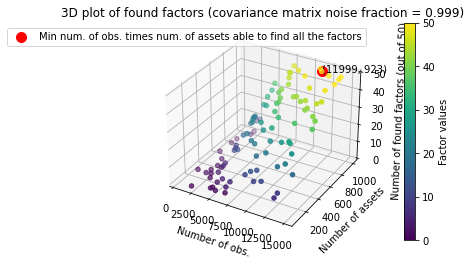

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming Ts, Ns, and Fs are numpy arrays and have been correctly computed
Ts_flat = Ts.flatten()
Ns_flat = Ns.flatten()
Fs_flat = Fs.flatten()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with colormap based on Fs values
scatter = ax.scatter(Ts_flat, Ns_flat, Fs_flat, c=Fs_flat, cmap='viridis')

# Adding a color bar to indicate the scale of Fs values
cbar = fig.colorbar(scatter, pad=0.1)
cbar.set_label('Factor values')

# Filter points where Fs[i] is 50
indices_50 = np.where(Fs_flat == 50)[0]

# If there are any points with Fs[i] == 50
if len(indices_50) > 0:
    # Find the index with the minimum Ts[i] * Ns[i] product among those
    min_product_index = indices_50[np.argmin((Ts_flat[indices_50] * Ns_flat[indices_50]))]

    # Highlight this point in red
    ax.scatter(Ts_flat[min_product_index], Ns_flat[min_product_index], Fs_flat[min_product_index], color='red', s=100, label='Min num. of obs. times num. of assets able to find all the factors')

    # Annotate the point with its coordinates
    ax.text(Ts_flat[min_product_index], Ns_flat[min_product_index], Fs_flat[min_product_index], f"({Ts_flat[min_product_index]}, {Ns_flat[min_product_index]})", color='black')

ax.set_xlabel('Number of obs.')
ax.set_ylabel('Number of assets')
ax.set_zlabel('Number of found factors (out of 50)')

# Setting the z axis limits as requested
ax.set_zlim(0, 50)
plt.title('3D plot of found factors (covariance matrix noise fraction = 0.999)')

# Adding a legend
ax.legend()

plt.show()



In [27]:
11880 * 990

11761200

In [28]:
Ts, Ns, Fs = get_TNFs(0.99, 100)

T=10250, N=50
sse:55441.77343985314
sse:55441.7712221775
sse:7758.847987304249
sse:7758.84817043184
found errPDFs0.99999
T=826, N=59
sse:2474.853743339609
sse:2474.8535784839455
sse:221.57496042049468
sse:221.57496659373226
found errPDFs0.99999
T=6417, N=69
sse:24357.332259096904
sse:24357.3307829186
sse:3607.9687766112065
sse:3607.9688484179287
found errPDFs0.99999
T=10374, N=78
sse:35741.1739718125
sse:35741.17217375881
sse:5810.889799141778
sse:5810.889848923371
found errPDFs0.99999
T=9240, N=88
sse:27148.96256846923
sse:27148.960747676614
sse:4391.6598549140435
sse:4391.659929999607
found errPDFs0.99999
T=5141, N=97
sse:11410.101831723572
sse:11410.100836886177
sse:1936.842220677473
sse:1936.8422341097212
found errPDFs0.99999
T=5885, N=107
sse:12039.400673116887
sse:12039.399569908446
sse:2141.9817980911016
sse:2141.9818240169966
found errPDFs0.99999
T=3159, N=117
sse:4680.158826615399
sse:4680.158361917103
sse:767.3681740586467
sse:767.3681772455298
found errPDFs0.99999
T=4032, N=

sse:406.3604823012188
sse:136.32883035650508
sse:136.32884567954608
sse:132.11483214942746
sse:132.1148322281038
sse:135.86885126905216
sse:135.8688358332604
sse:132.1147268169771
sse:132.1147268182487
sse:132.11472679009395
sse:132.11472679009324
found errPDFs0.6749955918168853
T=7416, N=309
sse:3047.6618899549735
sse:3047.6615283082065
sse:1050.876322469039
sse:1050.8763178215877
sse:1047.4305852718394
sse:1047.4305915541265
sse:1024.6323134868449
sse:1024.632323791634
sse:825.1383903903725
sse:825.1384198082394
sse:4635.697244710533
sse:4635.696761948335
sse:371.42421952873224
sse:371.4242630618699
sse:104.65727774321952
sse:104.65729276421098
sse:98.42660725866189
sse:98.42660334315505
sse:691.4143336645749
sse:691.4143716994745
sse:98.21422875044385
sse:98.2142313106587
sse:98.04194476314278
sse:98.04194481722092
sse:98.04186932160913
sse:98.04186932083414
sse:98.04186930572524
sse:98.04186930572546
found errPDFs0.6764710622091751
T=13038, N=318
sse:6411.389162793113
sse:6411.3884

sse:363.43824830636134
sse:363.43820596722463
sse:128.41292884154984
sse:128.4129269114034
sse:123.89004391815904
sse:123.89004614713046
sse:97.62367322338402
sse:97.62367708725805
sse:210.53034536808468
sse:210.53031639511875
sse:33.83878414470377
sse:33.83878849485876
sse:18.152435077544467
sse:18.152435685572648
sse:175.68697776628343
sse:175.6869514543691
sse:17.99772373265241
sse:17.99772385157426
sse:17.991777952727382
sse:17.99177794910924
sse:17.991772484175783
sse:17.991772484195945
sse:17.991772484016014
sse:17.991772484016018
found errPDFs0.6897596936380166
T=7974, N=443
sse:1827.5179796940693
sse:1827.5177556930914
sse:702.4052283344616
sse:702.4052229756177
sse:694.9320442024143
sse:694.932051698039
sse:647.2613449536985
sse:647.2613559764445
sse:231.8753503183997
sse:231.87538032019776
sse:25180885.088133622
sse:25180813.397242606
sse:1682.5194157076876
sse:1682.519201620672
sse:66.3272307750348
sse:66.32725264144128
sse:42.441143417223984
sse:42.44112912147064
sse:35.926

sse:20.746801085565206
sse:20.74680181747559
sse:105.05097787226978
sse:105.05094157860195
sse:20.71828327551082
sse:20.718283421316478
sse:20.71711790171841
sse:20.717117900259495
sse:20.71711778459932
sse:20.71711778460214
sse:20.717117784600248
sse:20.71711778460028
sse:20.71711778459924
sse:20.71711778460184
sse:20.717117784599864
sse:20.717117784600767
sse:20.71711778459929
sse:20.717117784601704
found errPDFs0.6747190400075318
T=13950, N=558
sse:2972.5550377905147
sse:2972.554672538575
sse:1086.7409102585566
sse:1086.7409009268508
sse:1074.385358976446
sse:1074.3853693124595
sse:1014.2268386604994
sse:1014.2268552241252
sse:279.12187295685334
sse:279.12192368517475
sse:17147025211319.09
sse:17112782533469.838
sse:3264.7225024594354
sse:3264.722111329217
sse:63.54278009037907
sse:63.54281184516469
sse:38.462156370788044
sse:38.4621407079502
sse:867.28455659291
sse:867.284583442104
sse:38.807446607476436
sse:38.80746230122217
sse:33.05609861601907
sse:33.056098593650226
sse:33.0560

C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: divide by zero encountered in true_divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5


sse:123.1162578686744
sse:123.11624957363813
sse:17.8278036413849
sse:17.827803886036502
found errPDFs0.99999
T=9810, N=654


C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: divide by zero encountered in true_divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: divide by zero encountered in true_divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: divide by zero encountered in true_divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: invalid value encountered i

sse:1321.2306035976856
sse:1321.230435465532
sse:517.0309284725048
sse:517.0309230099026
sse:507.4778348995495
sse:507.4778415968649
sse:450.3334279492449
sse:450.3334393479611
sse:14.862713256426758
sse:14.862709521558955
sse:262.86294473251
sse:262.86296641389254
sse:14.434368432685165
sse:14.434370655245875
sse:14.158402464091893
sse:14.158402571986741
sse:14.157781398691785
sse:14.157781394679564
sse:14.157780538363022
sse:14.157780538369126
sse:14.15778053836416
sse:14.15778053836415
sse:14.157780538362925
sse:14.157780538367714
found errPDFs0.6734082568710794
T=4648, N=664
sse:411.2100412411181
sse:411.20998819758273
sse:163.678766782999
sse:163.67876407650152
sse:156.36039963246327
sse:156.36040296574848
sse:115.84237476480476
sse:115.84237951205532
sse:465.49072811810083
sse:465.4906691525832
sse:37.19327523486085
sse:37.19328175573424
sse:8.270625246311905
sse:8.270624769050869
sse:23.46066104372494
sse:23.460666650368324
sse:8.213833064712752
sse:8.213833078468074
sse:8.21378

C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: divide by zero encountered in true_divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5


sse:112.21361410512121
sse:112.21360652430222
sse:16.777925438319407
sse:16.7779256007881
found errPDFs0.99999
T=3940, N=788


C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: divide by zero encountered in true_divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: divide by zero encountered in true_divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: divide by zero encountered in true_divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: invalid value encountered i

sse:238.09941521086083
sse:238.0993833453711
sse:96.73347328429013
sse:96.73347149795941
sse:91.69481651646373
sse:91.69481853123271
sse:64.39361474577049
sse:64.39361800921682
sse:478.67199273918516
sse:478.6719374268594
sse:18.242488807615395
sse:18.242492284615302
sse:6.9695973597181515
sse:6.969595028500657
sse:5.695382685965628
sse:5.6953838968462005
sse:175842.7893052855
sse:175842.7124782235
sse:288.7631464280676
sse:288.76311096539564
sse:4.885557394652638
sse:4.885557556611609
sse:4.8727398514088005
sse:4.87273983283614
sse:4.8725723006321395
sse:4.872572300869208
sse:4.872572273397598
sse:4.872572273397946
sse:4.872572273397711
sse:4.872572273397701
sse:4.872572273397606
sse:4.872572273397886
sse:4.872572273397581
sse:4.872572273397925
sse:4.872572273397582
sse:4.8725722733979335
sse:4.872572273397581
sse:4.872572273397925
found errPDFs0.6794916322104971
T=11970, N=798
sse:1294.2745948200252
sse:1294.2744258320038
sse:522.5471225979696
sse:522.5471168335048
sse:512.2063921978

C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: divide by zero encountered in true_divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5


sse:107.94128766024471
sse:107.94128017097502
sse:16.24161265685217
sse:16.241612787415736
found errPDFs0.99999
T=4375, N=875


C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: divide by zero encountered in true_divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: divide by zero encountered in true_divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: divide by zero encountered in true_divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: invalid value encountered i

sse:235.50524695778668
sse:235.50521576493327
sse:96.22706048084578
sse:96.22705865766464
sse:90.942243727586
sse:90.94224573727432
sse:61.57989276048131
sse:61.57989610417176
sse:611.6510083614075
sse:611.6509395188447
sse:15.332239384568041
sse:15.332242690394331
sse:22.395950005521435
sse:22.395943234669446
sse:4.158669071273774
sse:4.15866964215528
sse:128.5753031588778
sse:128.57528342949567
sse:3.9950207983068258
sse:3.9950208861314485
sse:3.991306403857183
sse:3.9913063989396154
sse:3.991294851007001
sse:3.9912948510464514
sse:3.9912948502829058
sse:3.9912948502829404
found errPDFs0.6799290945587744
T=12376, N=884
sse:1172.2240432395822
sse:1172.2238922823337
sse:465.5703517711636
sse:465.5703467019845
sse:456.67051956446494
sse:456.6705255507918
sse:401.3352854921528
sse:401.3352959675601
sse:17.127754000652544
sse:17.127741720772015
sse:224.89398537221035
sse:224.89400421634167
sse:8.1121169197141
sse:8.112120182127027
sse:105547.97236975245
sse:105547.95038384618
sse:1130.801

C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: divide by zero encountered in true_divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5


sse:106.95522432605165
sse:106.95521697491473
sse:16.861677856813632
sse:16.861677978970384
found errPDFs0.99999
T=7768, N=971


C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: divide by zero encountered in true_divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: divide by zero encountered in true_divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: divide by zero encountered in true_divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: invalid value encountered i

sse:473.849950516226
sse:473.8498860495846
sse:198.12389120786017
sse:198.12388807790958
sse:190.26186612100759
sse:190.26186982807297
sse:146.9176134349487
sse:146.91761928615134
sse:391.89608005131214
sse:391.8960252647897
sse:41.238807499519815
sse:41.23881574949146
sse:3.856700735341601
sse:3.856701375672496
sse:95.2219219894381
sse:95.22189960551233
sse:3.7853319815412627
sse:3.785331972219567
sse:3.7853175507237653
sse:3.7853175510484878
sse:3.785317533346232
sse:3.7853175333464213
sse:3.7853175333463605
sse:3.7853175333462907
sse:3.785317533346266
sse:3.785317533346408
sse:3.7853175333462725
sse:3.7853175333464124
sse:3.785317533346232
sse:3.7853175333464213
sse:3.7853175333462317
sse:3.7853175333464204
sse:3.785317533346262
sse:3.7853175333464373
sse:3.7853175333462317
sse:3.7853175333464204
sse:3.785317533346235
sse:3.785317533346407
sse:3.7853175333462317
sse:3.7853175333464204
sse:3.7853175333462525
sse:3.7853175333463955
sse:3.7853175333462317
sse:3.7853175333464204
sse:3.7

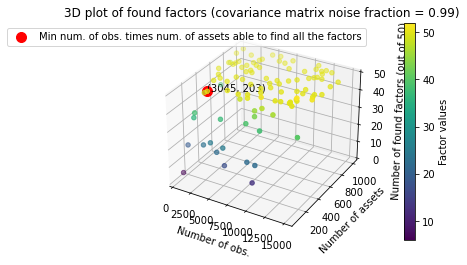

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming Ts, Ns, and Fs are numpy arrays and have been correctly computed
Ts_flat = Ts.flatten()
Ns_flat = Ns.flatten()
Fs_flat = Fs.flatten()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with colormap based on Fs values
scatter = ax.scatter(Ts_flat, Ns_flat, Fs_flat, c=Fs_flat, cmap='viridis')

# Adding a color bar to indicate the scale of Fs values
cbar = fig.colorbar(scatter, pad=0.1)
cbar.set_label('Factor values')

# Filter points where Fs[i] is 50
indices_50 = np.where(Fs_flat == 50)[0]

# If there are any points with Fs[i] == 50
if len(indices_50) > 0:
    # Find the index with the minimum Ts[i] * Ns[i] product among those
    min_product_index = indices_50[np.argmin((Ts_flat[indices_50] * Ns_flat[indices_50]))]

    # Highlight this point in red
    ax.scatter(Ts_flat[min_product_index], Ns_flat[min_product_index], Fs_flat[min_product_index], color='red', s=100, label='Min num. of obs. times num. of assets able to find all the factors')

    # Annotate the point with its coordinates
    ax.text(Ts_flat[min_product_index], Ns_flat[min_product_index], Fs_flat[min_product_index], f"({Ts_flat[min_product_index]}, {Ns_flat[min_product_index]})", color='black')

ax.set_xlabel('Number of obs.')
ax.set_ylabel('Number of assets')
ax.set_zlabel('Number of found factors (out of 50)')

# Setting the z axis limits as requested
ax.set_zlim(0, 50)
plt.title('3D plot of found factors (covariance matrix noise fraction = 0.99)')

# Adding a legend
ax.legend()

plt.show()


In [30]:
1908 * 318

606744

In [31]:
Ts, Ns, Fs = get_TNFs(0.9, 100)

T=14700, N=50
sse:69152.31408086662
sse:69152.31030612142
sse:16618.182536464446
sse:16618.182756321035
found errPDFs0.99999
T=8850, N=59
sse:35758.0710905087
sse:35758.06980537653
sse:8557.247212447637
sse:8557.247436703252
found errPDFs0.99999
T=5244, N=69
sse:16526.670217078456
sse:16526.66954933712
sse:4118.748146951931
sse:4118.748218049371
found errPDFs0.99999
T=9438, N=78
sse:29070.959872661726
sse:29070.95873085672
sse:6880.025246638878
sse:6880.025387861445
found errPDFs0.99999
T=1056, N=88
sse:2376.9829419166585
sse:2376.9828311737415
sse:533.5760138300591
sse:533.5760251619836
found errPDFs0.99999
T=7275, N=97
sse:18597.165890691715
sse:18597.165047870425
sse:4214.4713801796515
sse:4214.47144889094
found errPDFs0.99999
T=11342, N=107
sse:26182.622409934193
sse:26182.621370937857
sse:6473.600320342148
sse:6473.600463307495
found errPDFs0.99999
T=936, N=117
sse:1874.5767512306793
sse:1874.5766810473583
sse:390.41395463632426
sse:390.4139634287385
found errPDFs0.99999
T=5670, N

C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: divide by zero encountered in true_divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: divide by zero encountered in true_divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: divide by zero encountered in true_divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: invalid value encountered i

sse:606.5660517516193
sse:606.5660486799885
sse:318.89831611824286
sse:318.89832053796056
found errPDFs0.99999
T=11440, N=520
sse:6045.547294849525
sse:6045.547056443564
sse:1512.3941902291288
sse:1512.3942204773161
found errPDFs0.99999
T=4761, N=529
sse:2394.3590312834576
sse:2394.358954016682
sse:636.4243661174759
sse:636.4243788460908
found errPDFs0.99999
T=11858, N=539
sse:6034.874888883618
sse:6034.874654370493
sse:1512.3941902291288
sse:1512.3942204773161
found errPDFs0.99999
T=3288, N=548
sse:1641.1093588430283
sse:1641.1093074626392
sse:435.09737430377686
sse:435.0973829526412
found errPDFs0.99999
T=1116, N=558
sse:631.3672932307387
sse:631.3672888014827
sse:328.17658403021005
sse:328.1765885589428
found errPDFs0.99999
T=13064, N=568
sse:6319.209552193307
sse:6319.209299464788
sse:1579.8387080478278
sse:1579.8387396449189
found errPDFs0.99999
T=3462, N=577
sse:1627.7796934915045
sse:1627.7796433032358
sse:435.1310197950472
sse:435.13102846120273
found errPDFs0.99999
T=1174, N=5

C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: divide by zero encountered in true_divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5


sse:357.9869803450657
sse:357.986975670364
sse:247.84176497660658
sse:247.84176624306411
found errPDFs0.99999
T=9696, N=606


C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: divide by zero encountered in true_divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: divide by zero encountered in true_divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: divide by zero encountered in true_divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: invalid value encountered i

sse:4385.441969876232
sse:4385.4418060989865
sse:1107.8280614105652
sse:1107.8280835673484
found errPDFs0.99999
T=9240, N=616
sse:4121.359661508441
sse:4121.359510269143
sse:1040.4266508419878
sse:1040.4266716507295
found errPDFs0.99999
T=6250, N=625
sse:2665.691276000627
sse:2665.691185585611
sse:703.6783447471532
sse:703.6783588208611
found errPDFs0.99999
T=4445, N=635
sse:1870.6009405801437
sse:1870.6008786295463
sse:502.1347242667784
sse:502.1347343095734
found errPDFs0.99999
T=5152, N=644
sse:2137.8110022489495
sse:2137.810933820068
sse:569.2331071504489
sse:569.2331185352252
found errPDFs0.99999
T=2616, N=654
sse:1131.7661409988675
sse:1131.766113681097
sse:335.06352721689314
sse:335.063535163439
found errPDFs0.99999
T=3320, N=664
sse:1395.2362179844542
sse:1395.2361800246376
sse:370.0968212292244
sse:370.0968291325768
found errPDFs0.99999
T=14806, N=673
sse:6049.451892715615
sse:6049.451650746652
sse:1512.3941902291288
sse:1512.3942204773161
found errPDFs0.99999
T=7513, N=683
ss

C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: divide by zero encountered in true_divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5


sse:361.4110334198012
sse:361.4110289416141
sse:253.425349374682
sse:253.4253506511892
found errPDFs0.99999
T=7020, N=702


C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: divide by zero encountered in true_divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: divide by zero encountered in true_divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: invalid value encountered in multiply
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: divide by zero encountered in true_divide
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
C:\Users\seidm\AppData\Local\Temp\ipykernel_5928\967882101.py:7: RuntimeWarning: invalid value encountered i

sse:2635.092091572992
sse:2635.092002837866
sse:703.6783447471532
sse:703.6783588208611
found errPDFs0.99999
T=8544, N=712
sse:3251.924782532874
sse:3251.924669154102
sse:838.3075124456345
sse:838.3075292119529
found errPDFs0.99999
T=5768, N=721
sse:2149.4606000569056
sse:2149.460529939299
sse:569.2331071504489
sse:569.2331185352252
found errPDFs0.99999
T=2193, N=731
sse:897.7438207855681
sse:897.7438053656306
sse:323.2008770745164
sse:323.20088357890364
found errPDFs0.99999
T=1480, N=740
sse:636.7598134652104
sse:636.7598087935497
sse:331.85357634089166
sse:331.85358088995116
found errPDFs0.99999
T=13500, N=750
sse:4966.776564603721
sse:4966.776369364936
sse:1242.6586290359255
sse:1242.658653889347
found errPDFs0.99999
T=9880, N=760
sse:3537.2200887009535
sse:3537.2199657918977
sse:905.6629024701155
sse:905.6629205835551
found errPDFs0.99999
T=14611, N=769
sse:5239.37591517471
sse:5239.375706618244
sse:1310.0847453390008
sse:1310.0847715409582
found errPDFs0.99999
T=8569, N=779
sse:29

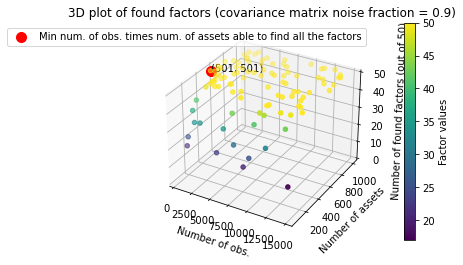

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming Ts, Ns, and Fs are numpy arrays and have been correctly computed
Ts_flat = Ts.flatten()
Ns_flat = Ns.flatten()
Fs_flat = Fs.flatten()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with colormap based on Fs values
scatter = ax.scatter(Ts_flat, Ns_flat, Fs_flat, c=Fs_flat, cmap='viridis')

# Adding a color bar to indicate the scale of Fs values
cbar = fig.colorbar(scatter, pad=0.1)
cbar.set_label('Factor values')

# Filter points where Fs[i] is 50
indices_50 = np.where(Fs_flat == 50)[0]

# If there are any points with Fs[i] == 50
if len(indices_50) > 0:
    # Find the index with the minimum Ts[i] * Ns[i] product among those
    min_product_index = indices_50[np.argmin((Ts_flat[indices_50] * Ns_flat[indices_50]))]

    # Highlight this point in red
    ax.scatter(Ts_flat[min_product_index], Ns_flat[min_product_index], Fs_flat[min_product_index], color='red', s=100,label='Min num. of obs. times num. of assets able to find all the factors')

    # Annotate the point with its coordinates
    ax.text(Ts_flat[min_product_index], Ns_flat[min_product_index], Fs_flat[min_product_index], f"({Ts_flat[min_product_index]}, {Ns_flat[min_product_index]})", color='black')

ax.set_xlabel('Number of obs.')
ax.set_ylabel('Number of assets')
ax.set_zlabel('Number of found factors (out of 50)')

# Setting the z axis limits as requested
ax.set_zlim(0, 50)
plt.title('3D plot of found factors (covariance matrix noise fraction = 0.9)')

# Adding a legend
ax.legend()

plt.show()



In [33]:
866 * 433

374978